In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import notebook_helper
import sys
import numpy as np
import imodelsx
import imodelsx.process_results
import mprompt.data.data
from mprompt.data.data import TASKS_D3
TASK_NAMES = list(TASKS_D3.keys())
sys.path.append('../experiments/')
# results_dir = '/home/chansingh/mntv1/mprompt/feb18_synthetic_sweep'
results_dir = '/home/chansingh/mntv1/mprompt/feb25'

In [54]:
r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename='01_explain.py')

100%|██████████| 66/66 [00:05<00:00, 11.66it/s]


In [56]:
r = r[r['module_num'] < 15]

In [89]:
r['top_contains_keywords'] = r['score_contains_keywords'].apply(lambda x: int(x[0]))
r['mean_contains_keywords'] = r['score_contains_keywords'].apply(lambda x: np.mean(x))
r['any_contains_keywords'] = r['score_contains_keywords'].apply(lambda x: int(np.max(x)))
r['task_str'] = r.apply(lambda row: mprompt.data.data.get_task_str(row['module_name'], row['module_num']), axis=1)
r['task_keyword'] = r['task_str'].apply(lambda task_str: mprompt.data.data.get_task_keyword(task_str))
r['task_name (groundtruth)'] = r['task_str'].apply(lambda s: s.split('_')[-1])
r['ngrams_restricted'] = ~(r['module_num_restrict'] == -1)
r = r.sort_values(by='top_score_synthetic', ascending=False).round(3)

default_params = {
    'noise_ngram_scores': 0,
    'module_num_restrict': -1,
}
rd = r
for k, v in default_params.items():
    rd = rd[rd[k] == v]

# Top results

In [90]:
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    display(rd[['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords',
   'top_score_synthetic', 'module_num']])

,task_keyword,top_explanation_init_strs,top_contains_keywords,top_score_synthetic,module_num
24,evacuation,"concept of evacuation, or the process of leaving a place in an emergency situation",1,0.471,5
44,atheistic,"atheism and related topics, such as theism, religious beliefs, and atheists",1,0.304,4
32,religious,religion,1,0.266,3
39,shelter,concept of shelter,1,0.243,8
64,rescue,action of rescuing or being rescued,1,0.233,14
2,crime,crime and criminal activity,1,0.214,7
31,water,water,1,0.213,13
0,terrorism,terrorism,1,0.192,6
30,sarcasm,sarcasm,1,0.173,0
1,health,health,1,0.158,12


### Explanation recovery accuracy results

In [91]:
groupings = ['noise_ngram_scores', 'ngrams_restricted']
metrics = ['any_contains_keywords', 'top_contains_keywords', 'mean_contains_keywords']
index_remap = {
    (0.0, False): 'Default',
    (0.0,  True): '+Ngram restriction',
    (3.0, False): '+Module noise',
}

g = (
    r
    .filter(groupings + metrics)
    .groupby(groupings)
    .mean()
    .round(3)
    .sort_values(by='any_contains_keywords', ascending=False)
).rename(
    columns={
    'any_contains_keywords': 'Acc (Top-K)',
    'top_contains_keywords': 'Acc (w/ synthetic)',
    'mean_contains_keywords': 'Acc (w/out synthetic)',
    },
)
g.index = [index_remap[x] for x in g.index.values]
display(g)

,Acc (Top-K),Acc (w/ synthetic),Acc (w/out synthetic)
Default,0.867,0.800,0.833
+Ngram restriction,0.733,0.667,0.693
+Module noise,0.667,0.600,0.600


### Does synthetic score help explanation recovery

In [88]:
groupings = ['noise_ngram_scores', 'ngrams_restricted', 'top_contains_keywords']
metrics = ['top_score_synthetic']
g2 = (
    r
    .filter(groupings + metrics)
    .groupby(groupings)
    .mean()
    .round(3)
    .pivot_table(index=['noise_ngram_scores', 'ngrams_restricted'],
                 columns='top_contains_keywords',
                 values='top_score_synthetic')
    .rename_axis(None, axis=1)  
    .rename(columns={
    True: 'Synthetic score (correct)',
    False: 'Synthetic score (incorrect)',
    })
)
g2.index = [index_remap[x] for x in g2.index.values]
display(g2)

,Synthetic score (incorrect),Synthetic score (correct)
Default,0.113,0.222
+Ngram restriction,0.111,0.222
+Module noise,0.104,0.217


[-0.47076654 -0.37118458 -0.31694565 -0.30576363 -0.3039334  -0.29500527
 -0.29426346 -0.28608282 -0.28608279 -0.26744149]


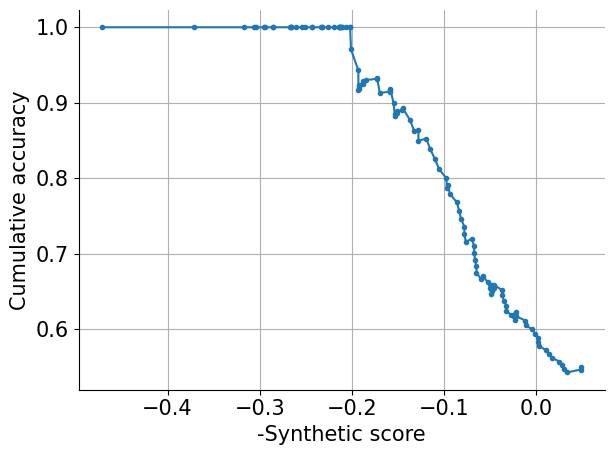

In [81]:
scores_synth = sum(r.score_synthetic.values, [])
corrects = sum(r.score_contains_keywords.values, [])
args = np.argsort(scores_synth)[::-1]
scores_synth = -np.array(scores_synth)[args]
corrects = np.array(corrects)[args]
print(scores_synth[:10])
plt.plot(scores_synth, np.cumsum(corrects) / np.arange(1, len(corrects) + 1), '.-')
plt.ylabel('Cumulative accuracy')
plt.xlabel('-Synthetic score')
plt.grid()
plt.show()

# Details

In [ ]:
# display full strings
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', 200):
    display(
        rd
        .filter(['task_keyword', 'top_explanation_init_strs', 'top_contains_keywords', 'top_score_synthetic', 'module_num'])
        # .filter(['top_score_contains_keywords', 'top_score_synthetic', 'top_explanation_init_strs', 'explanation_init_ngrams', 'module_num'])
        # .filter(['top_explanation_init_strs', 'explanation_init_ngrams', 'top_strs_added'])
        # .filter(['explanation_init_strs', 'explanation_init_ngrams',])
        # .head(n=20)
    )